# Am I a Cat?

In [245]:
# import numpy as np
import flickrapi
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import requests
from io import BytesIO
%matplotlib inline
import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [246]:
api_key = u'928b2147562ac58cc1bd3dd31cbb9fc7'
api_secret = u'144bdb71b15d5aa6'
flickr = flickrapi.FlickrAPI(api_key, api_secret)

In [247]:
def buildPhotoConnect(keyword1, keyword2):
    keyword1 = keyword1
    keyword2 = keyword2
    dir_tr = 'train'
    dir_ts = 'test'
    dir_ctg1 = keyword1
    dir_ctg2 = keyword2
    photos_ctg1 = flickr.walk(text=keyword1, tag_mode='all', tags=keyword1,extras='url_c',\
                     sort='relevance', per_page=2000)
    photos_ctg2 = flickr.walk(text=keyword2, tag_mode='all', tags=keyword2,extras='url_c',\
                     sort='relevance', per_page=2000)
    print(keyword1, keyword2)
    return photos_ctg1, photos_ctg2

In [248]:
def makeDirectory(dir_ctg1, dir_ctg2):
    import os
    dir_tr = 'train'
    dit_ts = 'test'
    dir_tr_exists = os.path.isdir(dir_tr)
    dir_ts_exists = os.path.isdir(dir_ts)

    if not dir_tr_exists:
        os.mkdir(dir_tr)
        print("Making directory %s" % dir_tr)
        dir_tr_ctg1 = dir_tr + '/' + dir_ctg1
        dir_tr_ctg2 = dir_tr + '/' + dir_ctg2
        if not os.path.isdir(dir_tr_ctg1):
            os.mkdir(dir_tr_ctg1)
            print("Making directory %s" % dir_tr_ctg1)
        if not os.path.isdir(dir_tr_ctg2):
            os.mkdir(dir_tr_ctg2)
            print("Making directory %s" % dir_tr_ctg2)
    else:
        print("Will store images in directory %s" % dir_tr)
    
    if not dir_ts_exists:
        os.mkdir(dir_ts)
        print("Making directory %s" % dir_ts)
        dir_ts_ctg1 = dir_ts + '/' + dir_ctg1
        dir_ts_ctg2 = dir_ts + '/' + dir_ctg2
        if not os.path.isdir(dir_ts_ctg1):
            os.mkdir(dir_ts_ctg1)
            print("Making directory %s" % dir_ts_ctg1)
        if not os.path.isdir(dir_ts_ctg2):
            os.mkdir(dir_ts_ctg2)
            print("Making directory %s" % dir_ts_ctg2)
    else:
        print("Will store images in directory %s" % dir_ts)
    return dir_tr_ctg1, dir_tr_ctg2, dir_ts_ctg1, dir_ts_ctg2

In [250]:
keyword1 = 'cat'
keyword2 = 'animal'
photos_ctg1, photos_ctg2 = buildPhotoConnect(keyword1, keyword2)
dr_tr1, dr_tr2, dr_ts1, dr_ts2 = makeDirectory(keyword1, keyword2)
#makeDirectory(keyword1, keyword2)

cat animal
Making directory train
Making directory train/cat
Making directory train/animal
Making directory test
Making directory test/cat
Making directory test/animal


In [280]:
def downloadPhoto(tr_num, ts_num, keyword, photos_ctg, dir_tr, dir_ts):

    import warnings
    
    im_tr = tr_num
    im_ts = ts_num
    i = 0
    nrow = 64
    ncol = 64
    for photo in photos_ctg:
        url=photo.get('url_c')
        if not (url is None):
        
            # Create a file from the URL
            # This may only work in Python3
            response = requests.get(url)
            file = BytesIO(response.content)
        
            # Read image from file
            im = skimage.io.imread(file)
        
            # Resize images
            im1 = skimage.transform.resize(im,(nrow,ncol),mode='constant')
                
            # Convert to uint8, suppress the warning about the precision loss
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                im2 = skimage.img_as_ubyte(im1)
    
            # Save the image
            if(i<im_tr):
                local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format(dir_tr,'animal', i)  
                skimage.io.imsave(local_name, im2)  
            else:
                local_name = '{0:s}/{1:s}_{2:04d}.jpg'.format(dir_ts,'animal', i-im_tr)  
                skimage.io.imsave(local_name, im2)      
            i = i + 1        
        if (i >= (im_tr+im_ts)):        
            break

In [257]:
downloadPhoto(1000, 300, 'cat', photos_ctg1, dr_tr1, dr_ts1)
downloadPhoto(1000, 300, 'animal', photos_ctg2, dr_tr2, dr_ts2)

KeyboardInterrupt: 

In [281]:
# from keras.preprocessing.image import ImageDataGenerator
nrow = 64
ncol = 64
train_data_dir = './train'
batch_size = 1000
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [282]:
test_data_dir = './test'
batch_size = 300
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 600 images belonging to 2 classes.


In [285]:
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')    
    else:
        # Color image.  
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)    
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

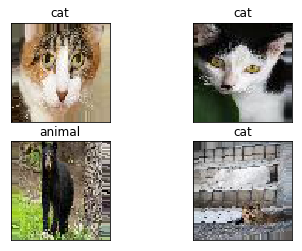

In [286]:
X,y=train_generator.next()
nplot = 4
for i in range(nplot):    
    plt.subplot(2,2,i+1)
    disp_image(X[i,:,:,:])
    if(y[i]==1):
        plt.title("cat")
    else:
        plt.title("animal")

In [287]:
X.shape

(1000, 64, 64, 3)

In [288]:
train_X_flattern=X.reshape(X.shape[0],-1).T
print(train_X_flattern.shape)

(12288, 1000)


In [289]:
test_set_x_orig,test_set_y_orig=test_generator.next()
test_X_flattern=test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print(test_X_flattern.shape)

(12288, 300)


In [290]:
test_y_flattern=test_set_y_orig.reshape(test_set_y_orig.shape[0],-1).T
train_y_flattern=y.reshape(y.shape[0],-1).T

In [291]:
print(train_y_flattern.shape)

(1, 1000)


In [292]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [293]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [294]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    A, cache = sigmoid(np.dot(w.T, X) + b) # compute activation
    cost = -1 / m * (np.dot(Y, np.log(A).T) + np.dot((1 - Y), np.log(1 - A).T))      # compute cost
  
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [295]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [296]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    
    A, cache = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [297]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [298]:
d = model(train_X_flattern, train_y_flattern, test_X_flattern, test_y_flattern, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.925510
Cost after iteration 200: 0.770339
Cost after iteration 300: 0.688642
Cost after iteration 400: 0.635586
Cost after iteration 500: 0.594203
Cost after iteration 600: 0.559178
Cost after iteration 700: 0.528479
Cost after iteration 800: 0.501050
Cost after iteration 900: 0.476209
Cost after iteration 1000: 0.453475
Cost after iteration 1100: 0.432500
Cost after iteration 1200: 0.413046
Cost after iteration 1300: 0.395009
Cost after iteration 1400: 0.378531
Cost after iteration 1500: 0.364412
Cost after iteration 1600: 0.354231
Cost after iteration 1700: 0.347180
Cost after iteration 1800: 0.340856
Cost after iteration 1900: 0.334818
train accuracy: 90.5 %
test accuracy: 69.0 %


learning rate is: 0.01
train accuracy: 72.4 %
test accuracy: 64.66666666666666 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 77.9 %
test accuracy: 69.66666666666666 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 71.3 %
test accuracy: 63.333333333333336 %

-------------------------------------------------------



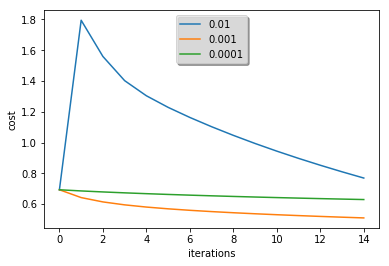

In [299]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_X_flattern, train_y_flattern, test_X_flattern, test_y_flattern, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

### Now we start to build our own deep neural network.

We will write two helper functions that will initialize the parameters for our model. The first function will be used to initialize parameters for a two layer model. The second one will generalize this initialization process to L layers.

In [300]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [301]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [302]:
parameters = initialize_parameters(3,2,1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[ 0.]
 [ 0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[ 0.]]


### L-layer Neural Network

In [303]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [304]:
parameters = initialize_parameters_deep([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[ 0.]
 [ 0.]
 [ 0.]]


### Linear Forward

In [305]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [306]:
A, W, b = linear_forward_test_case()

Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

Z = [[ 3.26295337 -1.23429987]]


### Linear-Activation-Forward

In [307]:
def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

In [308]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [309]:
A_prev, W, b = linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
print("With sigmoid: A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
print("With ReLU: A = " + str(A))

With sigmoid: A = [[ 0.96890023  0.11013289]]
With ReLU: A = [[ 3.43896131  0.        ]]


### L-Layer Model

In [310]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, 
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [311]:
X, parameters = L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))

AL = [[ 0.17007265  0.2524272 ]]
Length of caches list = 2


### Cost Function

In [312]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [313]:
Y, AL = compute_cost_test_case()

print("cost = " + str(compute_cost(AL, Y)))

cost = 0.414931599615


### Backward propagation module
linear backward

In [314]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, cache[0].T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

### Linear-Activation backward

In [315]:
def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [316]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.
    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [317]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

### L-Model Backward

In [318]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]

    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 2)], caches". Outputs: "grads["dA" + str(l + 1)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Update Parameters

In [319]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

# Build a two-layer neural network

In [320]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [321]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1". Output: "A1, cache1, A2, cache2".
    
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
        # Compute cost
        cost = compute_cost(A2, Y)
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693098643474234
Cost after iteration 100: 0.6921644836542725
Cost after iteration 200: 0.6897671142229165
Cost after iteration 300: 0.6822331759824332
Cost after iteration 400: 0.6636591129544422
Cost after iteration 500: 0.6312424845070603
Cost after iteration 600: 0.5930417641453568
Cost after iteration 700: 0.5596707522173651
Cost after iteration 800: 0.5315931574606093
Cost after iteration 900: 0.5056444950911856
Cost after iteration 1000: 0.4801411832742987
Cost after iteration 1100: 0.5053582498663113
Cost after iteration 1200: 0.48866455106025947
Cost after iteration 1300: 0.47495200600379245
Cost after iteration 1400: 0.46323200794833896
Cost after iteration 1500: 0.45099775434231315
Cost after iteration 1600: 0.4385071877530873
Cost after iteration 1700: 0.42657534195600977
Cost after iteration 1800: 0.4146664016697905
Cost after iteration 1900: 0.403833684990042
Cost after iteration 2000: 0.39380384079961556
Cost after iteration 2100: 0.3835696921698

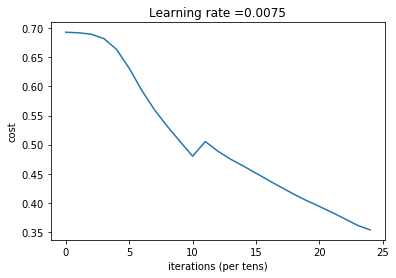

In [322]:
parameters = two_layer_model(train_X_flattern, train_y_flattern, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

In [323]:
def predict_two_linear_model(X, Y, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
    A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
    
    Y_prediction = np.zeros((1,Y.shape[1]))
    print(Y.shape)
    print(Y_prediction.shape)
    print(A2.shape[1])
    
    for i in range(A2.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A2[0, i] >= 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
         
    assert(Y_prediction.shape == (1, Y.shape[1]))
    
    return Y_prediction

In [324]:
# Predict test/train set examples
Y_predictions_train = predict_two_linear_model(train_X_flattern, train_y_flattern, parameters)
Y_predictions_test  = predict_two_linear_model(test_X_flattern, test_y_flattern, parameters)

# Print train/test Errors
print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_predictions_train - train_y_flattern)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_predictions_test - test_y_flattern)) * 100))



(1, 1000)
(1, 1000)
1000
(1, 300)
(1, 300)
300
train accuracy: 83.5 %
test accuracy: 68.66666666666666 %


# Build an L-Layer neural netword

In [325]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

In [326]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    (n_x, n_h, n_y) = layers_dims
    
    # Parameters initialization.
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693099
Cost after iteration 100: 0.692164
Cost after iteration 200: 0.689767
Cost after iteration 300: 0.682233
Cost after iteration 400: 0.663659
Cost after iteration 500: 0.631242
Cost after iteration 600: 0.593042
Cost after iteration 700: 0.559671
Cost after iteration 800: 0.531593
Cost after iteration 900: 0.505644
Cost after iteration 1000: 0.480141
Cost after iteration 1100: 0.505358
Cost after iteration 1200: 0.488665
Cost after iteration 1300: 0.474952
Cost after iteration 1400: 0.463232
Cost after iteration 1500: 0.450998
Cost after iteration 1600: 0.438507
Cost after iteration 1700: 0.426575
Cost after iteration 1800: 0.414666
Cost after iteration 1900: 0.403834
Cost after iteration 2000: 0.393804
Cost after iteration 2100: 0.383570
Cost after iteration 2200: 0.372640
Cost after iteration 2300: 0.361423
Cost after iteration 2400: 0.353535


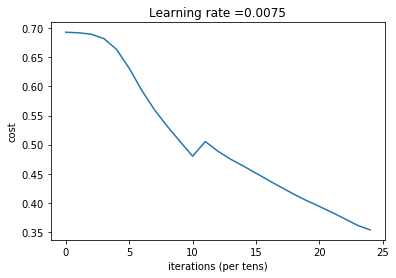

In [327]:
parameters = L_layer_model(train_X_flattern, train_y_flattern, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost = True)

In [330]:
def predict_L_layer_model(X, Y, parameters):
    
    AL, caches = L_model_forward(X, parameters)
    
    Y_prediction = np.zeros((1,Y.shape[1]))
    
    for i in range(AL.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if AL[0, i] >= 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
         
    assert(Y_prediction.shape == (1, Y.shape[1]))
    
    return Y_prediction

In [331]:
# Predict test/train set examples
Y_predictions_train = predict_L_layer_model(train_X_flattern, train_y_flattern, parameters)
Y_predictions_test  = predict_L_layer_model(test_X_flattern, test_y_flattern, parameters)

# Print train/test Errors
print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_predictions_train - train_y_flattern)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_predictions_test - test_y_flattern)) * 100))

train accuracy: 83.5 %
test accuracy: 68.66666666666666 %
